Département de génie électrique - Polytechnique Montréal

Méthodes d'optimisation et d'apprentissage pour les réseaux électriques - ELE8453

TP2 version 2: H2024


# <font color='#18a2f2'> **TP-2: Reconfiguration du réseau de distribution** </font>




__Objectifs__

Les objectifs du TP-2 sont:
1. implémenter la reconfiguration du réseau comme un problème d'optimisation convexe et;
2. calculer la solution de la reconfiguration du réseau formulée par cvxpy.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda uninstall pyscipopt
#!conda install -c conda-forge pyscipopt

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...

PackagesNotFoundError: The following packages are missing from the target environment:
  - pyscipopt




In [ ]:
!pip install numpy
!pip install cvxpy
!pip install mosek

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 131.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 76.9 MB/s eta 0:00:00


In [ ]:

import cvxpy as cp
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [ ]:
!git clone https://github.com/ALLabMTL/OPF_Tools

Cloning into 'OPF_Tools'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 237 (delta 104), reused 170 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (237/237), 12.55 MiB | 7.64 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
from OPF_Tools import *

Pour ce TP, vous aurez besoin d'un solver __MISOCP__ ou __MISDP__. Pour voir les solvers installés sur votre machine, exécutez la prochaine cellule:

In [ ]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


Pour savoir quels types de problèmes sont pris en charge par un solver, consultez la section «Choosing a solver» de la page suivante:
https://www.cvxpy.org/tutorial/advanced/index.html

$\texttt{Gurobi}$ est solver qui vous permet de de résoudre ces deux types de problème. Il est possible d'obtenir une licence académique gratuitement en vous inscrivant avec votre adresse courriel de Polytechnique. Les instructions pour l'installation sont disponibles à la section «Individual Academic Licenses» de la page suivante : https://www.gurobi.com/academia/academic-program-and-licenses/.

$\texttt{SCIP}$ est une bonne option gratuite qui peut être utilisée également.


## <font color='#a618f2'> **Exercice 1 - Le réseau IEEE 9-bus** </font>


Nous souhaitons reconfigurer le réseau IEEE 9-bus décrit à la Figure 1 avec les exigences suivantes:
1. Le réseau doit être radial.
2. Un interrupteur existe sur chaque ligne.
3. Les tensions de toutes les barres doivent être entre 0.9 et 1.1 pu.

Importer les images "9bus.png" et "10bus.png" dans le dossier "content" du Notebook pour afficher les images des réseaux étudiés.

**FIGURE 1 - Réseau IEEE 9-bus**

![9 bus network](https://raw.githubusercontent.com/ALLabMTL/Images/main/9bus.png)



### Données

In [ ]:
# Chargement du cas 9 bus
case9 = loadCase('OPF_Tools/cases/case9.json')

In [ ]:
#Extraction de la matrice admittance
Y = case9.adj
#print(Y)

#Extraction de la matrice de limites de puissances apparentes
Sij = case9.smax
#print(Sij)

#Extraction de la matrice de limites de tensions
v_lim = case9.getVlim()
#print(v_lim)

#Extraction des lignes
lines = case9.getLines()
lines_switch = lines

print(lines)

[(0, 3), (3, 4), (4, 5), (2, 5), (5, 6), (6, 7), (7, 1), (7, 8), (8, 3)]


In [ ]:
# Chargement des données du cas 9 bus
n = case9.N
# Valeur de base (MVA)
baseMVA = case9.mva

# Données des charges
Load_data = case9.loadData
# Données des générateurs
Gen_data = case9.genData

# Données de coût global
Costs_data = case9.cost

#Très grand nombre (contraintes disjonctives)
M=1000
case9.displayData()
print(baseMVA)

,P_d [MVa],Q_d [MVar]
0,0.00,0.00
1,0.00,0.00
2,0.00,0.00
3,0.00,0.00
4,0.90,0.30
5,0.00,0.00
6,1.00,0.35
7,0.00,0.00
8,1.25,0.50


,P_max [Mva],P_min [Mva],Q_max [MVar],Q_min [MVar]
0,2.5,0.1,3.0,-3.0
1,3.0,0.1,3.0,-3.0
2,2.7,0.1,3.0,-3.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0


,from bus,to bus,R (p.u.),X (p.u.),S_max (MVA)
0,1.0,4.0,0.0000,0.0576,250.0
1,4.0,5.0,0.0170,0.0920,250.0
2,5.0,6.0,0.0390,0.1700,150.0
3,3.0,6.0,0.0000,0.0586,300.0
4,6.0,7.0,0.0119,0.1008,150.0
5,7.0,8.0,0.0085,0.0720,250.0
6,8.0,2.0,0.0000,0.0625,250.0
7,8.0,9.0,0.0320,0.1610,250.0
8,9.0,4.0,0.0100,0.0850,250.0


,c2 [$/MW^2],c1 [$/MW],c0 [$]
0,0.1100,5.0,150.0
1,0.0850,1.2,600.0
2,0.1225,1.0,335.0
3,0.0000,0.0,0.0
4,0.0000,0.0,0.0
5,0.0000,0.0,0.0
6,0.0000,0.0,0.0
7,0.0000,0.0,0.0
8,0.0000,0.0,0.0


100


__Astuce:__ Il peut être intéressant définir les différents ensembles du problème: <br>
- $\mathcal{L}$ : l'ensemble des lignes unidirectionnelles du réseau. <br>
- $\mathcal{L}^{s}$ : l'ensemble des lignes du réseau avec un interrupteur. <br>
- $\mathcal{N}^{r}$ : l'ensemble des noeuds racines du réseau (générateurs). <br>

Ces ensembles peuvent être définis sur python à l'aide de listes. Il vous sera possible d'itérer sur celles-ci afin d'ajouter les contraintes appropriées.

### <font color='orange'> **1.a Formuler la reconfiguration en minimisant les pertes résistives du réseau.** </font>


In [ ]:
yij = np.conj(Y) #Objectif

### <font color='orange'> **1.b Implémenter la reconfiguration formulée dans Python et la résoudre par une relaxation.** </font>


>**Astuce!** La librairie `pandapower` offre une multitude d'outils permettant la visualisation de la configuration du réseau. `NetworkX` pourrait aussi vous aider de manière plus générale à partir de la matrice de topologie résultante.

#### **Variables**

Commencer par les variables de l'EPO ordinaire

In [ ]:
# matrice de tension
W = cp.Variable((n,n), hermitian=True)
p = cp.Variable((n))
q = cp.Variable((n))

# variables de puissances de lignes
Pij = cp.Variable((n,n))
Qij = cp.Variable((n,n))
v_min=0.9
v_max=1.1

# variables de génération
p_g = cp.Variable(n)
q_g = cp.Variable(n)
p_d = cp.Variable(n)
q_d = cp.Variable(n)

generateur = [0,1,2]
load = [4,6,8]


Les variables spécifiques au problème de reconfiguration sont:
- $z_{ij}$ et $z_{ji}$, qui indiquent la direction de l'écoulement de puissance. Ces variables sont définies comme des variables continues pour rendre le problème plus efficace d'un point vu computationnel.
- $\chi_{ij}$, qui indique le statut des interrupteurs. Il s'agit d'une variable binaire.

__Astuce:__ Il est possible de définir un variable binaire avec la commande $\texttt{cp.Variable(..., boolean=True)}$.
- $\tau_{ij}$ et $\rho_{ij}$ sont les écoulements de puissance d'une ligne lorsque son interrupteur est fermé.


In [ ]:
#Variables spécifique au problème de reconfiguration
chi = cp.Variable((n,n), boolean=True)
z = cp.Variable((n,n), boolean=True)
tau = cp.Variable((n,n))
rho = cp.Variable((n,n))
m = chi.value

#### **Contraintes - EPO**

Débuter par ajouter les contraintes liées à L'EPO ordinaire. Il s'agit du même ensemble admissible que l'exercice 4 du TP-1.   <br>
__Attention !__ N'oublier pas de remplacer cette contrainte: <br>
### $$p_{ij} + j q_{ij} = (W_{ii}-W_{ij})y^{*}_{ij}, \quad \forall ij \in \mathcal{L}$$

par celle-ci :
### $$ \tau_{ij}  + j\rho_{ij} = (W_{ii}-W_{ij})y^{*}_{ij}, \quad \forall ij \in \mathcal{L}$$

In [ ]:
# contraintes EPO
constraints=[]

for i in range (n):
  constraints += [p[i]==cp.sum(Pij[i,:])]
  constraints += [q[i]==cp.sum(Qij[i,:])]

  constraints += [cp.real(W[i,i])>=v_min**2,
                  cp.real(W[i,i])<=v_max**2]
#pourquoi utiliser p_d et p_g
  if i in generateur:
    constraints += [p[i]<=Gen_data[i,0],
                    p[i]>=Gen_data[i,1]]
    constraints += [q[i]<=Gen_data[i,2],
                    q[i]>=Gen_data[i,3]]
  if i in load:
    constraints += [p[i]==-Load_data[i,0],
                    q[i]==-Load_data[i,1]]


  for j in np.arange(0,n):
    constraints += [Pij[i,j]**2 + Qij[i,j]**2 <= Sij[i,j]**2]
    constraints += [tau[i,j] + 1j*rho[i,j] == (W[i,i]-W[i,j])*yij[i,j]]
    constraints += [cp.norm(cp.hstack([2*W[i,j],(W[i,i]-W[j,j])])) <= cp.real(W[i,i]+W[j,j])]
    constraints += [cp.real(W[i,j]) == cp.real(W[j,i])]
    constraints += [cp.imag(W[i,j]) == -cp.imag(W[j,i])]


#### **Contraintes de radialité**

Les contraintes de radialité sont les suivantes:

\begin{align}
  z_{ij} &\ge 0\\
  z_{ij} &=0, \quad j\in\mathcal{N}^r\\
  z_{ij}+z_{ji} &= 1, \quad ij\in \mathcal{L}\setminus\mathcal{L}^s\\
  z_{ij}+z_{ji} &= \chi_{ij},\quad ij\in\mathcal{L}^s\\
  \sum_i z_{ij} &=1,\quad j\in\mathcal{N}\setminus\mathcal{N}^r
\end{align}

Puisque toutes les lignes du réseau possèdent un interrupteur, la contrainte suivante peut être omise: <br>
$$z_{ij}+z_{ji}=1,\quad ij \in \mathcal{L}\backslash \mathcal{L}^{s}$$  



In [ ]:
# contraintes de radialité
L = []
for line in lines:
  i = line[0]
  j = line[1]
  L.append([i,j])
  L.append([j,i])

for a in L:
  i = a[0]
  j = a[1]
  constraints += [z[i,j] + z[j,i] == chi[i,j]]
for i in range(n):
  for j in range(n):
    constraints += [z[i,j] >= 0]

    #if abs(Y[i,j] != 0):
      #constraints += [z[i,j] + z[j,i] == 1]
    if j < 3:
      constraints += [z[i,j] == 0] #Generateurs
for j in range(3,n):
    constraints += [cp.sum(z[:,j]) == 1]



#### **Contraintes des interrupteurs**


Ajouter les contraintes disjonctives. Celles-ci permet d'égaler les variables $\rho_{ij}$ et $\tau_{ij}$ aux écoulements de puissance lorsqu'un interrupteur est fermé.



In [ ]:
# contraintes des interrupteurs
M = 1e3

for a in L:
  i = a[0]
  j = a[1]
  constraints += [cp.abs(Pij[i,j]) <= cp.multiply(M,chi[i,j])]
  constraints += [cp.abs(Qij[i,j]) <= cp.multiply(M,chi[i,j])]
  constraints += [cp.abs(Pij[i,j] - tau[i,j]) <= cp.multiply(M, (1-chi[i,j]))]
  constraints += [cp.abs(Qij[i,j] - rho[i,j]) <= cp.multiply(M, (1-chi[i,j]))]

for i in range(n):
  for j in range(n):
    if np.abs(yij[i,j]) == 0:
      constraints += [chi[i,j] == 0]
      constraints += [tau[i,j] == 0]
      constraints += [rho[i,j] == 0]
      constraints += [z[i,j] == 0]
      constraints += [Pij[i,j] == 0]
      constraints += [Qij[i,j] == 0]



#### **Fonction objectif**

__Astuce:__ la fonction $\texttt{cp.sum()}$ permet d'effectuer l'opération $\sum_{ij} X_{ij},\quad X \in \mathbb{R}^{m \times n}$.

In [ ]:
cost = cp.sum(Pij)

#### **Résolution**

In [ ]:
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver='MOSEK')
#0.0637

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.


### <font color='orange'> **1.c Rapporter la topologie du réseau (les interrupteurs fermés et ouvers) et la génération de chaque générateur** </font>



In [ ]:
for line in range(n):

    i=int(lines[line][0])-1
    j=int(lines[line][1])-1
    if chi.value[i+1,j+1] <= 0.5 :
        print((i+1,j+1), "Ouvert")

    else :
        print((i+1,j+1), "Fermé")

(0, 3) Fermé
(3, 4) Fermé
(4, 5) Ouvert
(2, 5) Fermé
(5, 6) Ouvert
(6, 7) Fermé
(7, 1) Fermé
(7, 8) Ouvert
(8, 3) Fermé


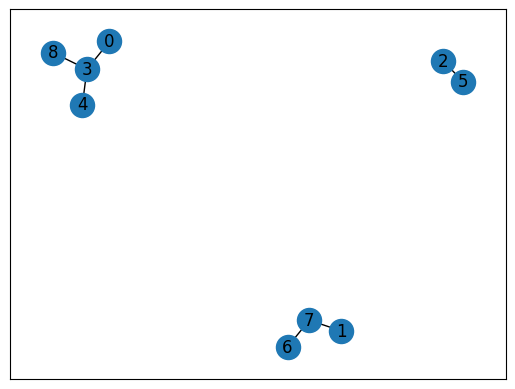

In [ ]:
import networkx as nx
m = chi.value
net = nx.from_numpy_array(m)
nx.draw_networkx(net)

## <font color='#a618f2'> **Exercice 2 - Le réseau IEEE 9-bus modifié** </font>

Nous modifions le réseau IEEE 9-bus en insérant une barre 10 entre les barres 9 et 4. La charge A injecte une ddemande réactive à la barre 9, et une petite charge D est également ajoutée sur la barre 10. Le réseau modifié est décrit à la figure 2.

Les paramètres modifiés dans ce réseau se trouvent dans les tableaus 1 et 2. Pour les autres paramètres qui n'apparaissent pas dans les tableuax, ils sont les mêmes que ceux du réseau initial.

**FIGURE 2 - Réseau IEEE 9-bus modifié**

![10 bus network](https://raw.githubusercontent.com/ALLabMTL/Images/main/10bus.png)


| Charge | A | D |
|:--------:|:--------:|:--------:|
|  Barre   |  9   |  10   |
|  Demande p [MW]   |  125   |  10   |
|  Demande q [MVAR]   |  -50   |  0   |


| Ligne | 1-4 | 9-10 | 10-4 |
|:---------:|:--------:|:--------:|:--------:|
|  R [p.u.]  |  0   |  0.01   |  0.01   |
|  X [p.u.]   |  0.0576   |  0.085   |  0.085   |
|  $\bar{S}$ [MVAR]   |  250   |  250   |  250   |

#### **Données**

In [ ]:
# Chargement du cas 10 bus
case10 = loadCase('OPF_Tools/cases/case10tp2.json')

In [ ]:
#Extraction de la matrice admittance
Y = case10.adj

#Extraction de la matrice de limites de puissances apparentes
Sij = case10.smax

#Extraction de la matrice de limites de tensions
v_lim = case10.getVlim()

#Extraction des lignes
lines = case10.getLines()
case10.displayData()

,P_d [MVa],Q_d [MVar]
0,0.00,0.00
1,0.00,0.00
2,0.00,0.00
3,0.00,0.00
4,0.90,0.30
5,0.00,0.00
6,1.00,0.35
7,0.00,0.00
8,1.25,-0.50
9,0.10,0.00


,P_max [Mva],P_min [Mva],Q_max [MVar],Q_min [MVar]
0,2.5,0.1,3.0,-3.0
1,3.0,0.1,3.0,-3.0
2,2.7,0.1,3.0,-3.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


,from bus,to bus,R (p.u.),X (p.u.),S_max (MVA)
0,1.0,4.0,0.0000,0.0576,250.0
1,4.0,5.0,0.0170,0.0920,250.0
2,5.0,6.0,0.0390,0.1700,150.0
3,3.0,6.0,0.0000,0.0586,300.0
4,6.0,7.0,0.0119,0.1008,150.0
5,7.0,8.0,0.0085,0.0720,250.0
6,8.0,2.0,0.0000,0.0625,250.0
7,8.0,9.0,0.0320,0.1610,250.0
8,9.0,10.0,0.0100,0.0850,250.0
9,10.0,4.0,0.0100,0.0850,250.0


,c2 [$/MW^2],c1 [$/MW],c0 [$]
0,0.1100,5.0,150.0
1,0.0850,1.2,600.0
2,0.1225,1.0,335.0
3,0.0000,0.0,0.0
4,0.0000,0.0,0.0
5,0.0000,0.0,0.0
6,0.0000,0.0,0.0
7,0.0000,0.0,0.0
8,0.0000,0.0,0.0
9,0.0000,0.0,0.0


In [ ]:
# Chargement des données du cas 10 bus
n = case10.N
print(n)
# Valeur de base (MVA)
baseMVA = case10.mva

# Données des charges
Load_data = case10.loadData
# Données des générateurs
Gen_data = case10.genData

# Données de coût global
Costs_data = case10.cost

10


### <font color='orange'> **2.a Refaire 1.a-1.c pour le réseau modifié.** </font>



In [ ]:
# matrice de tension
W = cp.Variable((n,n), hermitian=True)
p = cp.Variable((n))
q = cp.Variable((n))

# variables de puissances de lignes
Pij = cp.Variable((n,n))
Qij = cp.Variable((n,n))
v_min=0.9
v_max=1.1

# variables de génération
p_g = cp.Variable(n)
q_g = cp.Variable(n)
p_d = cp.Variable(n)
q_d = cp.Variable(n)

generateur = [0,1,2]
load = [4,6,8,9]

yij = np.conj(Y) #Objectif

#Variables spécifique au problème de reconfiguration
chi = cp.Variable((n,n), boolean=True)
z = cp.Variable((n,n), boolean=True)
tau = cp.Variable((n,n))
rho = cp.Variable((n,n))
m = chi.value

# contraintes EPO
constraints=[]

for i in range (n):
  constraints += [p[i]==cp.sum(Pij[i,:])]
  constraints += [q[i]==cp.sum(Qij[i,:])]

  constraints += [cp.real(W[i,i])>=v_min**2,
                  cp.real(W[i,i])<=v_max**2,
                  cp.imag(W[i,i]) == 0]
#pourquoi utiliser p_d et p_g
  if i in generateur:
    constraints += [p[i]<=Gen_data[i,0],
                    p[i]>=Gen_data[i,1]]
    constraints += [q[i]<=Gen_data[i,2],
                    q[i]>=Gen_data[i,3]]
  if i in load:
    constraints += [p[i]==-Load_data[i,0],
                    q[i]==-Load_data[i,1]]


  for j in np.arange(0,n):
    constraints += [Pij[i,j]**2 + Qij[i,j]**2 <= Sij[i,j]**2]
    constraints += [tau[i,j] + 1j*rho[i,j] == (W[i,i]-W[i,j])*yij[i,j]]
    constraints += [cp.norm(cp.hstack([2*W[i,j],(W[i,i]-W[j,j])])) <= cp.real(W[i,i]+W[j,j])]

# contraintes de radialité
L = []
for line in lines:
  i = line[0]
  j = line[1]
  L.append([i,j])
  L.append([j,i])

for a in L:
  i = a[0]
  j = a[1]
  constraints += [z[i,j] + z[j,i] == chi[i,j]]
for i in range(n):
  for j in range(n):
    constraints += [z[i,j] >= 0]

    #if abs(Y[i,j] != 0):
      #constraints += [z[i,j] + z[j,i] == 1]
    if j < 3:
      constraints += [z[i,j] == 0] #Generateurs
for j in range(3,n):
    constraints += [cp.sum(z[:,j]) == 1]

# contraintes des interrupteurs
M = 1e3

for a in L:
  i = a[0]
  j = a[1]
  constraints += [cp.abs(Pij[i,j]) <= cp.multiply(M,chi[i,j])]
  constraints += [cp.abs(Qij[i,j]) <= cp.multiply(M,chi[i,j])]
  constraints += [cp.abs(Pij[i,j] - tau[i,j]) <= cp.multiply(M, (1-chi[i,j]))]
  constraints += [cp.abs(Qij[i,j] - rho[i,j]) <= cp.multiply(M, (1-chi[i,j]))]

for i in range(n):
  for j in range(n):
    if np.abs(yij[i,j]) == 0:
      constraints += [chi[i,j] == 0]
      constraints += [tau[i,j] == 0]
      constraints += [rho[i,j] == 0]
      constraints += [z[i,j] == 0]
      constraints += [Pij[i,j] == 0]
      constraints += [Qij[i,j] == 0]


In [ ]:
cost = 0
for i in range(n):
    cost += Costs_data[i,0]*(p[i]*baseMVA)**2 +  Costs_data[i,1]*(p[i]*baseMVA) + Costs_data[i,2]
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver='MOSEK')


/usr/local/lib/python3.11/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/usr/local/lib/python3.11/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/usr/local/lib/python3.11/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


1188.750002682474

(0, 3) Fermé
(3, 4) Fermé
(4, 5) Ouvert
(2, 5) Fermé
(5, 6) Ouvert
(6, 7) Fermé
(7, 1) Fermé
(7, 8) Ouvert
(8, 9) Fermé
(9, 3) Fermé


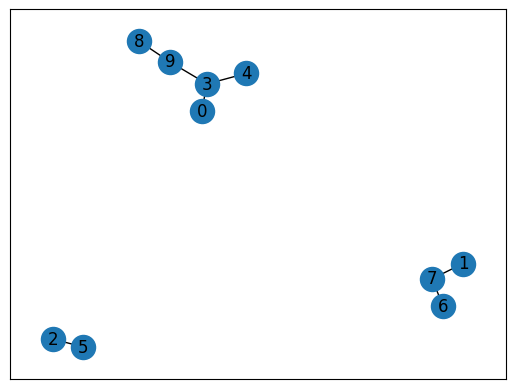

In [ ]:
for line in range(n):
    i=int(lines[line][0])-1
    j=int(lines[line][1])-1
    if chi.value[i+1,j+1] <= 0.5 :
        print((i+1,j+1), "Ouvert")

    else :
        print((i+1,j+1), "Fermé")
import networkx as nx
m = chi.value
net = nx.from_numpy_array(m)
nx.draw_networkx(net)